In [17]:
import os

os.listdir('/root/data')
os.chdir('/BreastCancerDiagnosisMRI/')


In [18]:
os.getcwd()

'/BreastCancerDiagnosisMRI'

In [3]:
!pip install tensorflow==2.17
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 23.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 39.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 39.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 15.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 37.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3


2025-03-03 23:03:38.636667: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 23:03:38.641172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 23:03:38.654596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 23:03:38.676201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 23:03:38.682645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 23:03:38.699417: I tensorflow/core/platform/cpu_feature_gu

In [23]:

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/BreastCancerDiagnosisMRI/code/')

MODEL_WEIGHTS_PATH = '/BreastCancerDiagnosisMRI/model/pretrained_model_weights.npy'


DATA_PATH = '/root/data/'

T1_POST_PATH = "T1_left_02_01.nii"
DCE_IN_PATH = "T1_left_slope1.nii"
DCE_OUT_PATH = "T1_left_slope2.nii"            

T1_pre_nii_path = DATA_PATH + 'T1_left_01_01.nii' # If data already normalized, no need for T1pre image
MODALITY = 'axial'
SIDE = ''


os.chdir(os.getcwd())

# Load util functions
from utils import UNet_v0_2D_Classifier, load_and_preprocess, color_map, generate_gradCAM_image#, FocalLoss

# Load model architecture
model = UNet_v0_2D_Classifier(input_shape =  (512,512,3), pool_size=(2, 2), deconvolution=True, 
                              depth=6, n_base_filters=42, activation_name="softmax", L2=1e-5, USE_CLINICAL=True)
# Load pre-trained weights stored as numpy array to avoid tensorflow version incompatibility
loaded_weights = np.load(MODEL_WEIGHTS_PATH, allow_pickle=True, encoding='latin1')
model.set_weights(loaded_weights) # no need to compile model as we are just doing inference.

# Load and process data
all_subject_channels = [DATA_PATH + T1_POST_PATH, 
                        DATA_PATH + DCE_IN_PATH, 
                        DATA_PATH + DCE_OUT_PATH] 

X, shape = load_and_preprocess(all_subject_channels, T1_pre_nii_path=T1_pre_nii_path, side=SIDE, imaging_protocol=MODALITY, debug=False)


resampling to a resolution of 0.4 x 0.4mm..
cropping/padding to size 512 x 512 pixels..
normalizing by p95 from T1 pre..


Data preprocessed.. model inference
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step
prediction done..
Generating gradCAM heatmap..


<Figure size 640x480 with 0 Axes>

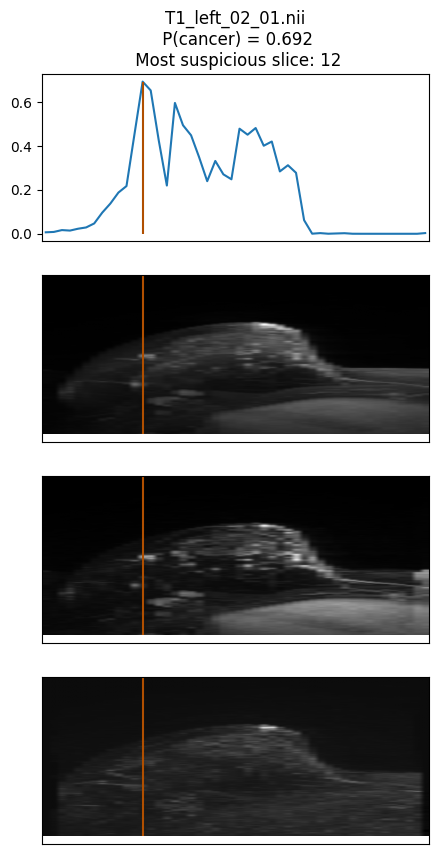

<Figure size 640x480 with 0 Axes>

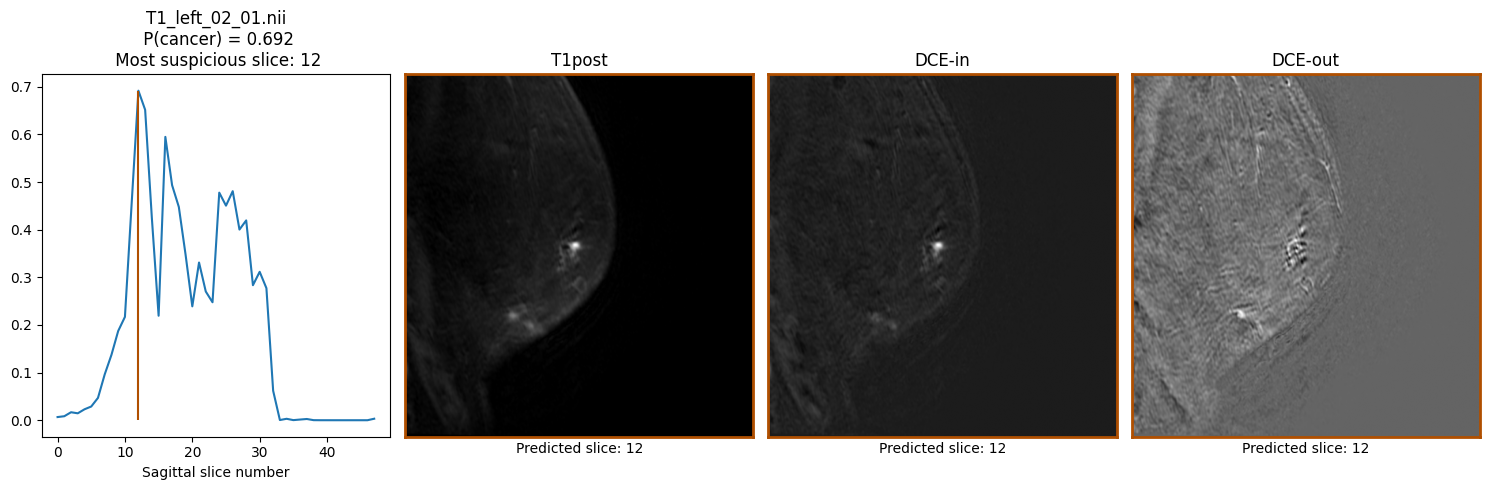

<Figure size 640x480 with 0 Axes>

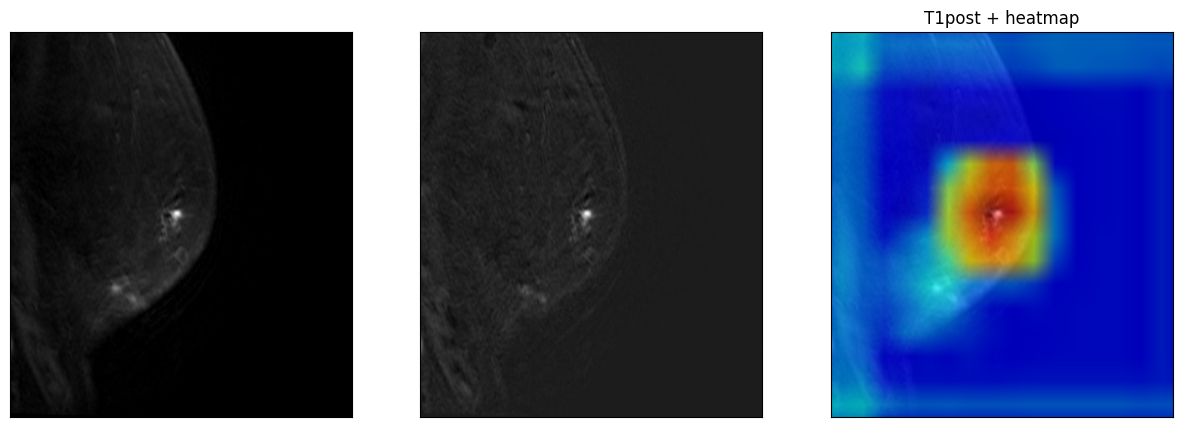

In [24]:

# Clinical and demographic information if available
MODE_CLINICAL = np.array([[0.  , 0.51, 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])
      
print('Data preprocessed.. model inference')    
preds = model.predict([X, np.tile(MODE_CLINICAL, (shape[0], 1))], batch_size=1, verbose=1)[:,-1]

# preds = model.predict([X, np.tile(MODE_CLINICAL, (shape[0], 1))], batch_size=1, use_multiprocessing=True, workers=10, verbose=0)[:,-1]
print('prediction done..')

global_prediction = np.max(preds)
max_slice = np.argwhere(preds == global_prediction)[0][0]   

# Generate gradCAM for in-slice visualization
print('Generating gradCAM heatmap..')
heatmap, img, superimposed_img = generate_gradCAM_image(model, X[max_slice:max_slice+1], MODE_CLINICAL ,alpha = 0.30)   
# from skimage.transform import resize
# heatmap_resized = resize(heatmap, output_shape=(512,512), anti_aliasing=True)

# Plot results    
rgb_color = color_map(global_prediction)

axial_projection_t1post = np.max(X[:,:,:,0],2)
axial_projection_slope1 = np.max(X[:,:,:,1],2)
axial_projection_slope2 = np.max(X[:,:,:,2],2)

plt.figure(1)
fig, ax = plt.subplots(4,1, sharex=True, figsize=(5,10))    

ax[0].set_title(f'{T1_POST_PATH.split("/")[-1]}\n P(cancer) = ' + str(np.round(global_prediction,3)) + f'\n Most suspicious slice: {max_slice}')
ax[0].plot(preds)
ax[0].vlines(max_slice,0,global_prediction,color=rgb_color)
ax[0].set_aspect('auto')

ax[1].imshow(np.rot90(axial_projection_t1post), cmap='gray')   
ax[1].set_aspect('auto'); ax[1].set_xticks([]); ax[1].set_yticks([])
ax[1].vlines(max_slice,0,512,color=rgb_color)
ax[1].set_aspect('auto');
   

ax[2].imshow(np.rot90(axial_projection_slope1), cmap='gray')   
ax[2].set_aspect('auto'); ax[1].set_xticks([]); ax[2].set_yticks([])
ax[2].vlines(max_slice,0,512,color=rgb_color)
ax[2].set_aspect('auto');
   

ax[3].imshow(np.rot90(axial_projection_slope2), cmap='gray')   
ax[3].set_aspect('auto'); ax[1].set_xticks([]); ax[3].set_yticks([])
ax[3].vlines(max_slice,0,512,color=rgb_color)
ax[3].set_aspect('auto');

plt.show()
# plt.savefig(project_directory + '/figures/fig1.png', dpi=300)
   

plt.figure(2)
fig, ax = plt.subplots(1,4, figsize=(15,5))    

ax[0].set_title(f'{T1_POST_PATH.split("/")[-1]}\n P(cancer) = '  + str(np.round(global_prediction,3)) + f'\n Most suspicious slice: {max_slice}')
ax[0].plot(preds)
ax[0].vlines(max_slice,0,global_prediction,color=rgb_color)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Sagittal slice number')
# ax[0].set_xticks(np.arange(len(preds)))

ax[1].set_title('T1post')
ax[1].imshow(np.rot90(X[max_slice,:,:,0]), cmap='gray' )
ax[1].set_xlabel(f'Predicted slice: {max_slice}'); ax[1].set_xticks([]); ax[1].set_yticks([])
ax[1].set_aspect('auto')
for spine in ax[1].spines.values():
    spine.set_edgecolor(rgb_color)  # Change color as desired
    spine.set_linewidth(2)  # Change thickness as desired


ax[2].set_title('DCE-in')
ax[2].imshow(np.rot90(X[max_slice,:,:,1]), cmap='gray' )
ax[2].set_xlabel(f'Predicted slice: {max_slice}'); ax[2].set_xticks([]); ax[2].set_yticks([])
ax[2].set_aspect('auto')
for spine in ax[2].spines.values():
    spine.set_edgecolor(rgb_color)  # Change color as desired
    spine.set_linewidth(2)  # Change thickness as desired

ax[3].set_title('DCE-out')
ax[3].imshow(np.rot90(X[max_slice,:,:,2]), cmap='gray' )
ax[3].set_xlabel(f'Predicted slice: {max_slice}'); ax[3].set_xticks([]); ax[3].set_yticks([])
ax[3].set_aspect('auto')
for spine in ax[3].spines.values():
    spine.set_edgecolor(rgb_color)  # Change color as desired
    spine.set_linewidth(2)  # Change thickness as desired

plt.tight_layout()
plt.show()

# plt.savefig(project_directory + '/fig2.png', dpi=300)



plt.figure(3)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(np.rot90(X[max_slice:max_slice+1][0,:,:,0]), cmap='gray', aspect="auto"), axes[0].set_xticks([]) , axes[0].set_yticks([])
axes[1].imshow(np.rot90(X[max_slice:max_slice+1][0,:,:,1]), cmap='gray', aspect="auto"), axes[1].set_xticks([]) , axes[1].set_yticks([])
axes[2].imshow(np.rot90(superimposed_img), aspect="auto"); axes[2].set_title('T1post + heatmap'); axes[2].set_xticks([]) , axes[2].set_yticks([])
plt.show()